In [12]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
PROJECT_DIR = os.getcwd()
RAW_TRAIN_DIR = os.path.join(PROJECT_DIR, "raw_data", "archive", "dataset_flat_structure", "train")
SMALL_DIR = os.path.join(PROJECT_DIR, "small_dataset")

In [ ]:
NUM_IMAGES_PER_CLASS = 100

os.makedirs(SMALL_DIR, exist_ok=True)

In [ ]:
for cls in os.listdir(RAW_TRAIN_DIR):
    src_class_dir = os.path.join(RAW_TRAIN_DIR, cls)
    dst_class_dir = os.path.join(SMALL_DIR, cls)
    os.makedirs(dst_class_dir, exist_ok=True)

    imgs = [f for f in os.listdir(src_class_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    if len(imgs) == 0:
        print(f" {cls}  No images")
        continue

    selected_imgs = random.sample(imgs, min(NUM_IMAGES_PER_CLASS, len(imgs)))
    for img in selected_imgs:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print("Small data was created ", SMALL_DIR)


Small data was created  /home/faisal/code/MrZeroX1/Aivine/small_dataset


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    SMALL_DIR,
    image_size=(224, 224),
    batch_size=8,
    label_mode='int'
)

Found 2281 files belonging to 23 classes.


In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Chrysanthemum_Bacterial_Leaf_Spot', 'Chrysanthemum_Healthy', 'Chrysanthemum_Septoria_Leaf_Spot', 'Hibiscus_Blight', 'Hibiscus_Healthy', 'Hibiscus_Necrosis', 'Hibiscus_Scorch', 'Money Plant_Money_Plant_Bacterial_Wilt', 'Money Plant_Money_Plant_Chlorosis', 'Money Plant_Money_Plant_Healthy', 'Money Plant_Money_Plant_Manganese_Toxicity', 'Rose_Black_Spot', 'Rose_Downy_Mildew', 'Rose_Healthy', 'Rose_Mosaic_Virus', 'Rose_Powdery_Mildew', 'Rose_Rust', 'Rose_Yellow_Mosaic_Virus', 'Turmeric_Aphid_Infestation', 'Turmeric_Blotch', 'Turmeric_Healthy', 'Turmeric_Leaf_Necrosis', 'Turmeric_Leaf_Spot']


In [ ]:
def preprocess(ds):
    images = []
    labels = []
    for batch_images, batch_labels in ds:
        batch_images = batch_images / 255.0
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    X = np.concatenate(images, axis=0)
    y = np.concatenate(labels, axis=0)
    y = to_categorical(y, num_classes=num_classes)
    return X, y

X, y = preprocess(train_ds)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data ready:", X_train.shape, X_test.shape)

Data ready: (1824, 224, 224, 3) (457, 224, 224, 3)


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_test, y_test, batch_size=32)

In [14]:
def initialize_model(input_shape=(224, 224, 3), num_classes=num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [15]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, verbose=1, monitor="val_loss", restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
57/57 [==============================] - 19s 320ms/step - loss: 3.2102 - accuracy: 0.0565 - val_loss: 3.0576 - val_accuracy: 0.1510
Epoch 2/50
57/57 [==============================] - 19s 329ms/step - loss: 2.8434 - accuracy: 0.1464 - val_loss: 2.6316 - val_accuracy: 0.2582
Epoch 3/50
57/57 [==============================] - 21s 371ms/step - loss: 2.5376 - accuracy: 0.2308 - val_loss: 2.3623 - val_accuracy: 0.3042
Epoch 4/50
57/57 [==============================] - 19s 334ms/step - loss: 2.2724 - accuracy: 0.2988 - val_loss: 1.9640 - val_accuracy: 0.4158
Epoch 5/50
57/57 [==============================] - 18s 321ms/step - loss: 1.9673 - accuracy: 0.3706 - val_loss: 1.8978 - val_accuracy: 0.3786
Epoch 6/50
57/57 [==============================] - 17s 296ms/step - loss: 1.8316 - accuracy: 0.4068 - val_loss: 1.8085 - val_accuracy: 0.4333
Epoch 7/50
57/57 [==============================] - 18s 317ms/step - loss: 1.6451 - accuracy: 0.4490 - val_loss: 1.7037 - val_accuracy: 0.4748

2025-10-23 10:41:27.616464: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19270528 bytes after encountering the first element of size 19270528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


57/57 [==============================] - 14s 242ms/step - loss: 0.7878 - accuracy: 0.7237 - val_loss: 0.7815 - val_accuracy: 0.7505
Epoch 29/50
57/57 [==============================] - 14s 233ms/step - loss: 0.7356 - accuracy: 0.7505 - val_loss: 0.8194 - val_accuracy: 0.7352
Epoch 30/50
57/57 [==============================] - 13s 229ms/step - loss: 0.8128 - accuracy: 0.7204 - val_loss: 1.1353 - val_accuracy: 0.6652
Epoch 31/50
57/57 [==============================] - 14s 252ms/step - loss: 0.7557 - accuracy: 0.7352 - val_loss: 0.8000 - val_accuracy: 0.7571
Epoch 32/50
57/57 [==============================] - 14s 236ms/step - loss: 0.7180 - accuracy: 0.7473 - val_loss: 0.7970 - val_accuracy: 0.7571
Epoch 32: early stopping


In [19]:
res = model.evaluate(val_generator, verbose=0)
print(f"\n Model Accuracy: {res[1]*100:.2f}%")


 Model Accuracy: 80.74%


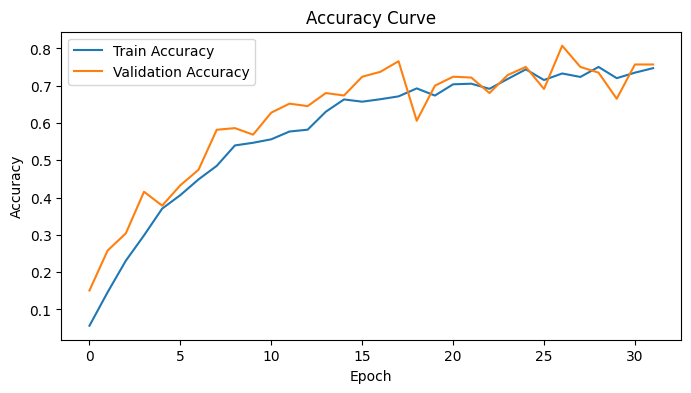

In [20]:
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()